# Monkey Pox Skin Lesion Classification

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

TensorFlow Version: 2.12.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Assembling the data in the work enviroment

In [2]:
WORK_DIR = '../input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images/'

CLASSES = [ 'Monkeypox_augmented',
            'Others_augmented']

IMG=224

IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )


# Feature Engineering the data

In [3]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=3192, shuffle=False)


Found 3192 images belonging to 2 classes.


# Working on basic showcasing of data from the existing data

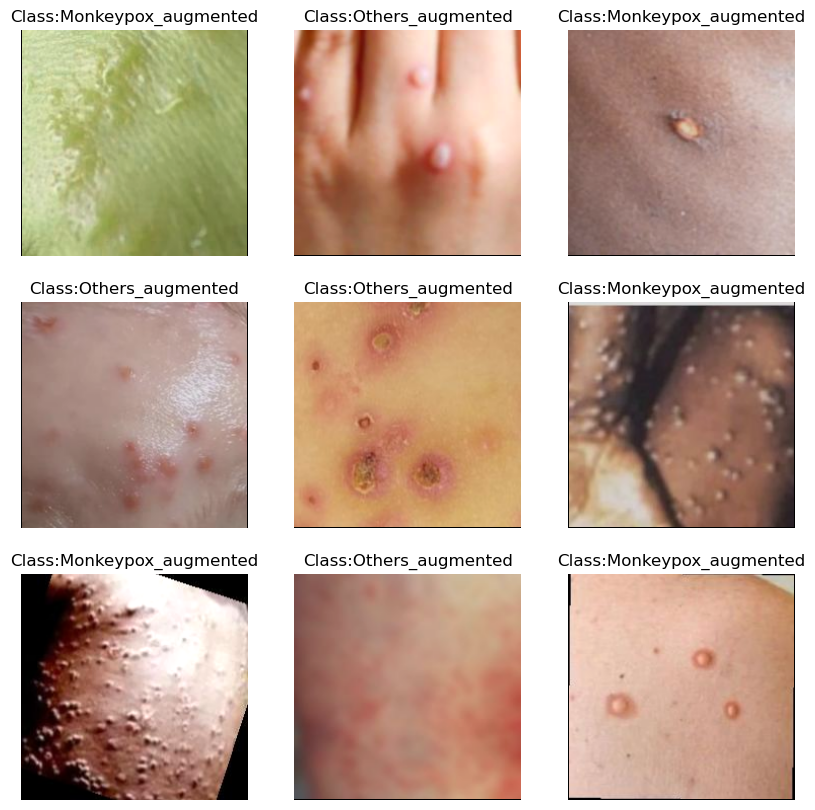

In [4]:
from random import randint
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 3192)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

# Creating Training and Testing data with labels

In [5]:
train_data, train_labels = train_data_gen.next()

In [6]:
print(train_data.shape, train_labels.shape)

(3192, 224, 224, 3) (3192, 2)


In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [8]:
print(train_data.shape)

(2297, 224, 224, 3)


# Creating a Convolutional Neural Network Function

In [9]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [10]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        MaxPool2D(),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
       
        dense_block(256, 0.3),
        dense_block(128, 0.2),
        dense_block(32, 0.2),
        Dense(2, activation='sigmoid')        
    ], name = "cnn_model")

    return model


# Creating a callback function

In [11]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
import tensorflow_addons as tfa
import tensorflow as tf

#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Constructing and Compiling the Model

In [13]:
#Defining other parameters for our CNN model
from tensorflow.keras import Sequential, Input

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=2)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=METRICS)

model.summary()



Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 sequential_7 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 14, 14, 64)        55

# Working with Epochs for better accuracy

In [14]:
EPOCHS = 100

history = model.fit(train_data, train_labels, 
                    validation_data=(val_data, 
                                     val_labels), 
                    callbacks=CALLBACKS,
                    batch_size=32, 
                    epochs=EPOCHS)

Epoch 1/100


2024-09-04 04:13:38.694768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_model/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


72/72 [==============================] - 20s 90ms/step - loss: 0.7492 - acc: 0.6317 - auc: 0.6443 - f1_score: 0.6233 - val_loss: 0.7705 - val_acc: 0.5983 - val_auc: 0.5997 - val_f1_score: 0.5279
Epoch 2/100
72/72 [==============================] - 4s 57ms/step - loss: 0.6581 - acc: 0.6744 - auc: 0.7005 - f1_score: 0.6602 - val_loss: 0.7154 - val_acc: 0.5774 - val_auc: 0.6226 - val_f1_score: 0.4250
Epoch 3/100
72/72 [==============================] - 4s 57ms/step - loss: 0.6296 - acc: 0.6835 - auc: 0.7234 - f1_score: 0.6638 - val_loss: 0.6654 - val_acc: 0.6400 - val_auc: 0.6556 - val_f1_score: 0.5809
Epoch 4/100
72/72 [==============================] - 4s 57ms/step - loss: 0.6138 - acc: 0.6874 - auc: 0.7342 - f1_score: 0.6703 - val_loss: 0.9063 - val_acc: 0.5687 - val_auc: 0.5525 - val_f1_score: 0.3625
Epoch 5/100
72/72 [==============================] - 4s 57ms/step - loss: 0.5801 - acc: 0.7118 - auc: 0.7670 - f1_score: 0.6925 - val_loss: 0.8907 - val_acc: 0.5652 - val_auc: 0.5260 - va

# Evaluating model on test data

In [15]:
#Evaluating the model on the data

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

10/10 [==============================] - 0s 16ms/step - loss: 0.2837 - acc: 0.9281 - auc: 0.9674 - f1_score: 0.9281
Testing Accuracy: 92.81%


In [16]:
pred_labels = model.predict(test_data)
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

10/10 [==============================] - 0s 13ms/step
                     precision    recall  f1-score   support

Monkeypox_augmented       0.95      0.91      0.93       162
   Others_augmented       0.91      0.95      0.93       158

          micro avg       0.93      0.93      0.93       320
          macro avg       0.93      0.93      0.93       320
       weighted avg       0.93      0.93      0.93       320
        samples avg       0.93      0.93      0.93       320



# Plotting the confusion matrix

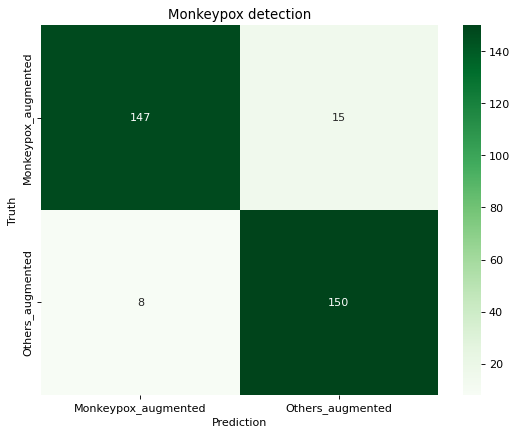

In [17]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Monkeypox detection')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [18]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 92.84 %
Matthew's Correlation Coefficient: 85.71 %


In [19]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)

18/18 [==============================] - 0s 15ms/step - loss: 0.3567 - acc: 0.9130 - auc: 0.9641 - f1_score: 0.9115


# Printing Training and Validation Accuracy

In [20]:
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

Training Accuracy: 99.91%
Validation Accuracy: 91.30%


# Plotting the trend of metrixs during training

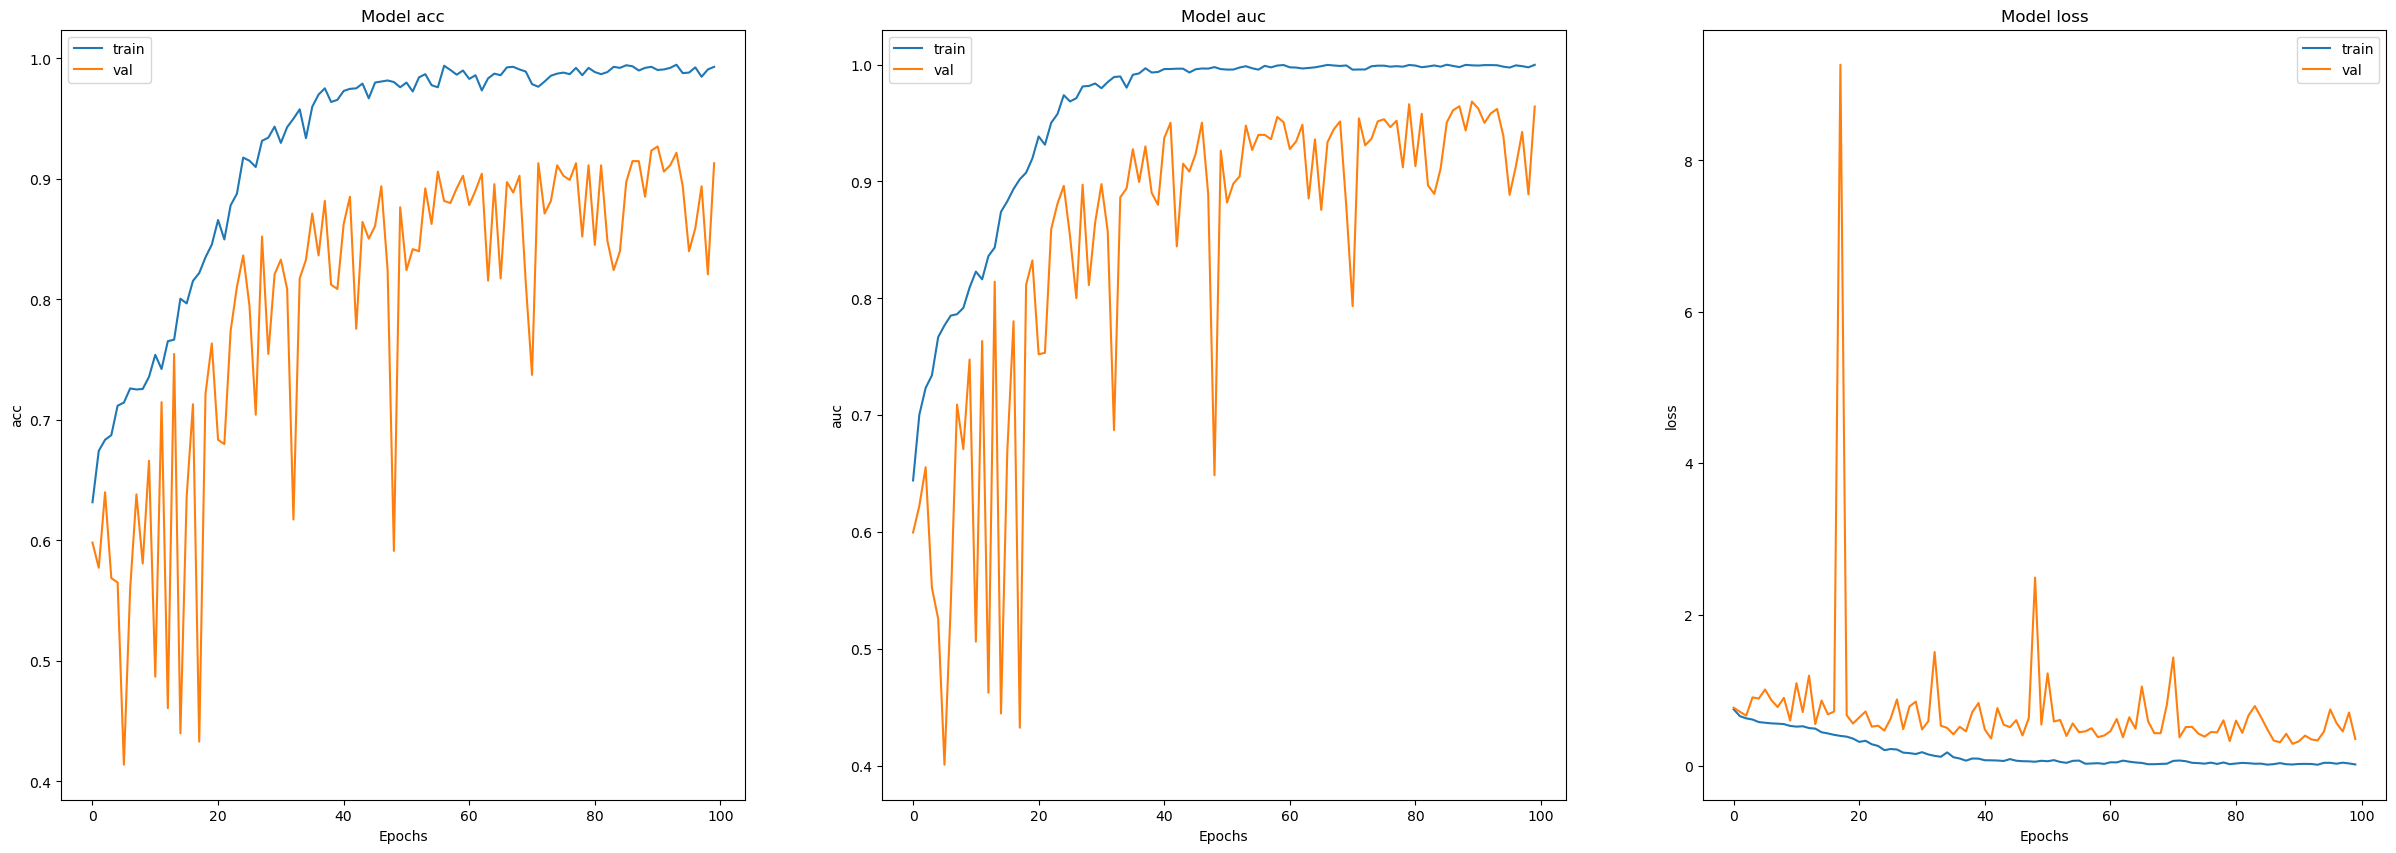

In [23]:


#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

